In [1]:
import tensorflow           as tf
import seaborn              as sns
import matplotlib.pyplot    as plt

from keras.models                   import load_model
from pathlib                        import Path
from keras.preprocessing.image      import ImageDataGenerator
from sklearn.metrics                import accuracy_score, precision_score, recall_score
from sklearn.metrics                import f1_score, confusion_matrix, roc_curve, auc

Configurar TensorFlow para usar la GPU

In [2]:
# Configurar TensorFlow para usar la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Elimina y recrea directorio split_imagenes, divide imágenes en carpetas de entrenamiento y validación

In [3]:
transformada = "mexh"

#Ruta al directoria split_imagenes
ruta_split_imagenes = Path(f"../../../../split_imagenes/{transformada}")

Se definen parámetros

In [4]:
# Definir rutas de las carpetas que contienen las imágenes
img_width, img_height   = 250, 250
input_shape             = (img_width, img_height, 3)

# Hiperparámetros
batch_size  = 16

Se crean los generadores de datos de imágenes

In [5]:
# Configurar el generador de datos de imágenes
valid_datagen = ImageDataGenerator(rescale=1./255)

# Cargar imágenes de validación
generador_validacion = valid_datagen.flow_from_directory(
    ruta_split_imagenes/"val",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 800 images belonging to 2 classes.


## **Parte 5:** Evaluación del modelo

Se evalua el mejor modelo guardado

In [6]:
mejor_modelo = load_model("modelo_generado/mejor_modelo.keras")
generador_validacion.reset()
resul_eva = mejor_modelo.evaluate(generador_validacion, verbose=False)

# Obtener los resultados de pérdida y accuracy
perdida = resul_eva[0]
accuracy = resul_eva[1]

print("Loss: {:.2f}".format(perdida))
print("Accuracy: {:.2%}".format(accuracy))

Loss: 0.46
Accuracy: 87.00%


Cálculo de diferentes métricas


Matriz de Confusión:


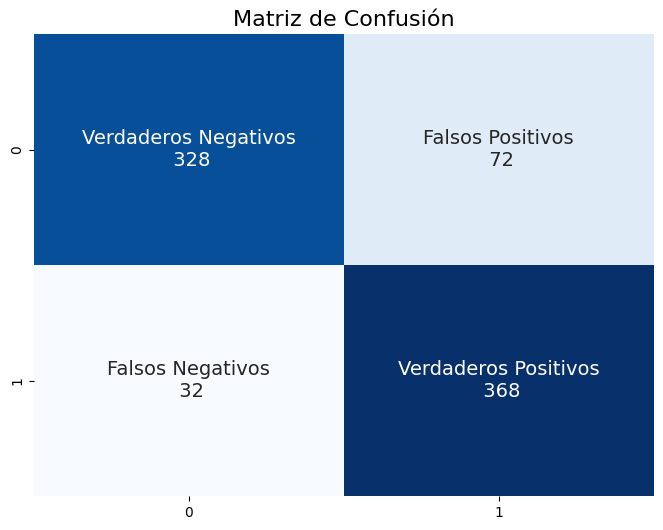

Accuracy:	87.00%
Sensitivity:	92.00%
Specificity:	82.00%
Precision:	83.64%
F1-score:	87.62%


In [7]:
# Obtener las predicciones del modelo
generador_validacion.reset()
y_pred_prob = mejor_modelo.predict(generador_validacion, verbose=False)

# Convertir las probabilidades en clases binarias usando un umbral (por ejemplo, 0.85)
y_pred = (y_pred_prob > 0.5).astype(int)

# Obtener las etiquetas verdaderas
y_test = generador_validacion.classes

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calcular métricas
accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1          = f1_score(y_test, y_pred)

# Calcular sensitivity y specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Imprimir resultados
print("\nMatriz de Confusión:")

# Define las etiquetas para los valores en la matriz de confusión
labels = [['Verdaderos Negativos\n', 'Falsos Positivos\n'],
          ['Falsos Negativos\n', 'Verdaderos Positivos\n']]

# Crear una nueva matriz combinando la matriz de confusión y las etiquetas
annot_matrix = [['{} {}'.format(label, value) for label, value in zip(row_labels, row)] for row_labels, row in zip(labels, conf_matrix)]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annot_matrix, cmap='Blues', fmt='', cbar=False, annot_kws={'size':14})
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

print("Accuracy:\t{:.2%}".format(accuracy))
print("Sensitivity:\t{:.2%}".format(sensitivity))
print("Specificity:\t{:.2%}".format(specificity))
print("Precision:\t{:.2%}".format(precision))
print("F1-score:\t{:.2%}".format(f1))

Curva roc y auc

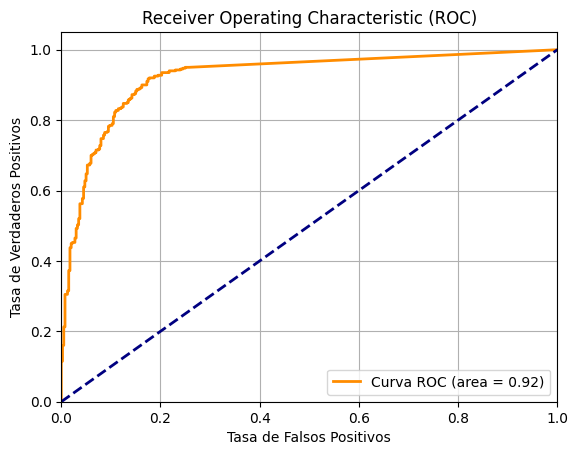

Área Bajo la Curva (AUC): 0.92


In [8]:
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Visualizar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Imprimir el AUC
print(f"Área Bajo la Curva (AUC): {roc_auc:.2f}")

Comportamiento de falsos positivos (FP) y falsos negativos (FN) utilizando diferentes umbrales

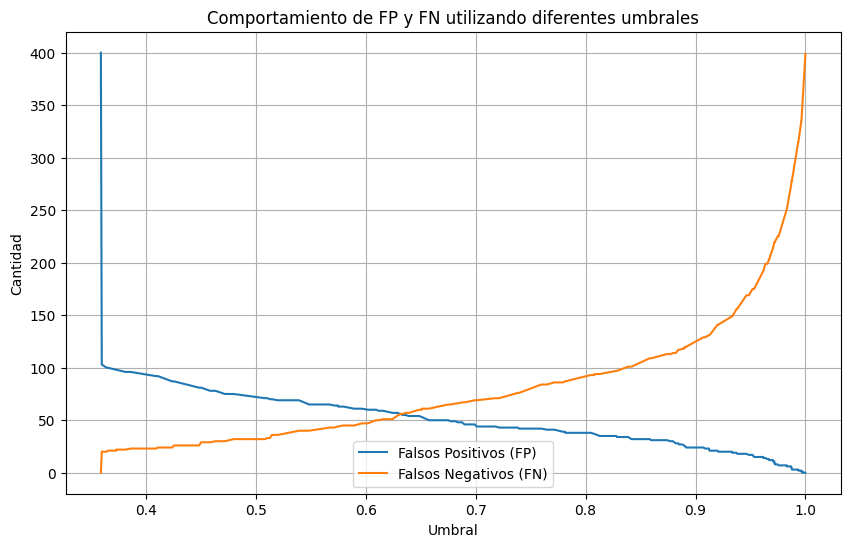

In [9]:
# Listas para almacenar los valores de FP y FN
fp_list = []
fn_list = []

# Calcular FP y FN para cada umbral
for threshold in thresholds:
    y_pred = (y_pred_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fp_list.append(fp)
    fn_list.append(fn)

# Graficar FP y FN para diferentes umbrales
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fp_list, label='Falsos Positivos (FP)')
plt.plot(thresholds, fn_list, label='Falsos Negativos (FN)')
plt.xlabel('Umbral')
plt.ylabel('Cantidad')
plt.title('Comportamiento de FP y FN utilizando diferentes umbrales')
plt.legend(loc='best')
plt.grid(True)
plt.show()